In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
train.shape

(891, 12)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
holdout = pd.read_csv("test.csv")
holdout.shape

(418, 11)

In [5]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"])
    return df

In [8]:
train = preprocess(train)
holdout = preprocess(holdout)

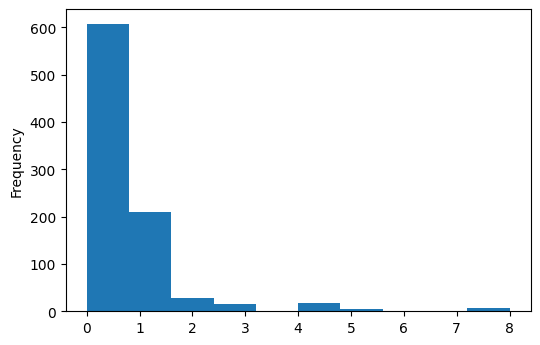

In [9]:
train["SibSp"].plot.hist()

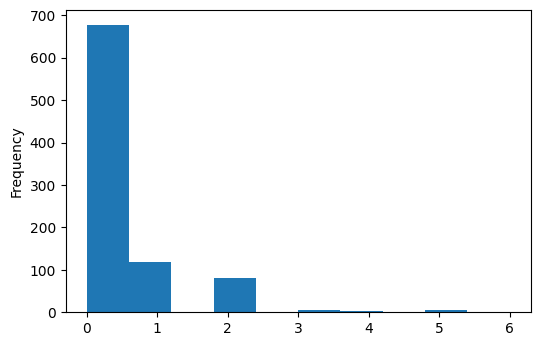

In [10]:
train['Parch'].plot.hist()

In [11]:
train[["SibSp", "Parch"]].dtypes

SibSp    int64
Parch    int64
dtype: object

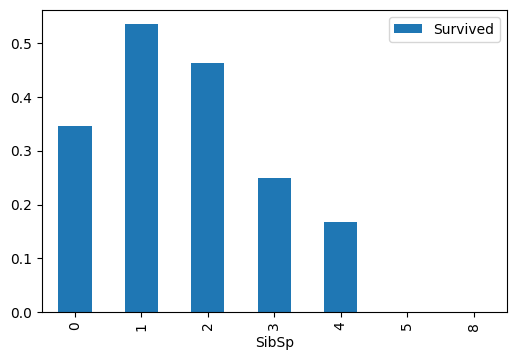

In [12]:
sibsp_pivot = train.pivot_table(index = 'SibSp', values='Survived')
sibsp_pivot.plot.bar()

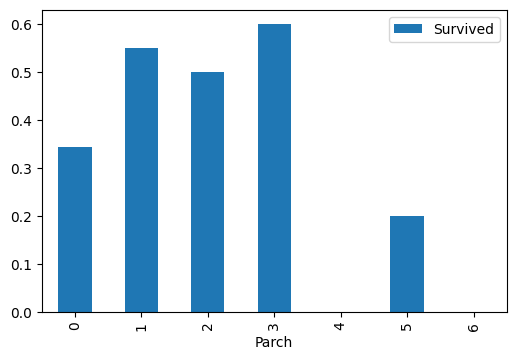

In [13]:
parch_pivot = train.pivot_table(index = 'Parch', values='Survived')
parch_pivot.plot.bar()

In [14]:
train[['SibSp', 'Parch']].isna().sum()

SibSp    0
Parch    0
dtype: int64

In [15]:
explore = train[['SibSp','Parch', 'Survived']].copy()
explore['famsize'] = explore[['SibSp','Parch']].sum(axis = 1)

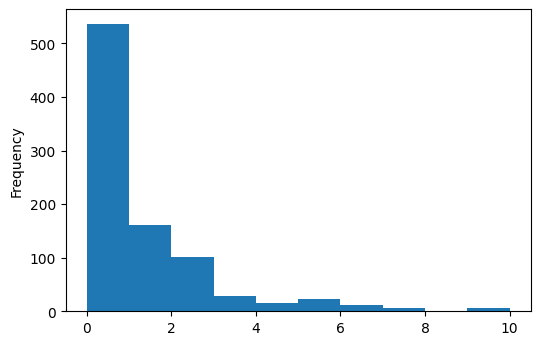

In [16]:
explore['famsize'].plot.hist()

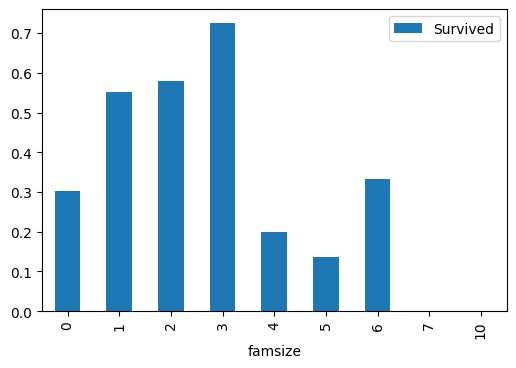

In [17]:
famsize_pivot = explore.pivot_table(index = 'famsize', values='Survived')
famsize_pivot.plot.bar()


The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The number of people without parents or sibilings are greater than any other.

The distribution for SibSp and Parch are right skewed.

In [18]:
def isalone(df):
    df["isalone"] = 0
    df.loc[df["SibSp"] + df["Parch"] == 0, "isalone"] = 1
    return df
        

In [19]:
train = isalone(train)
holdout = isalone(holdout)

In [20]:
def feature_selection(df):
    df = df.select_dtypes(exclude=['object', 'category'])
    df = df.dropna(axis = 1)
    features = df.columns.drop(["PassengerId", "Survived"])
    all_X = df[features]
    all_y = df["Survived"]
    forest = RandomForestClassifier(random_state = 1)
    rfecv = RFECV(forest, cv = 10)
    rfecv.fit(all_X, all_y)
    optimized_columns = all_X.columns[rfecv.support_]
    print(optimized_columns)
    return optimized_columns
    

In [21]:
selected_columns = feature_selection(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


In [22]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models =  [{
        "name": "LogisticRegression",
        "estimator" : LogisticRegression(),
        "hyperparameters" : {
            "solver" : ["newton-cg", "lbfgs", "liblinear"]
        }},
        {
        "name" : "KNeighborsClassifier",
        "estimator" : KNeighborsClassifier(),
        "hyperparameters" : {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]            
        }},
        {
        "name" : "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters" :{
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }]
    param_list = []
    for model in models:
        param_dict = {}
        print(model["name"])
        m = model['estimator']
        grid = GridSearchCV(m, param_grid = model['hyperparameters'])
        grid.fit(all_X, all_y)
        param_dict["score"] = grid.best_score_
        param_dict["parameter"] = grid.best_params_
        param_dict["model"] = grid.best_estimator_
        param_list.append(param_dict)
    return param_list
        
        

In [23]:
params = select_model(train, selected_columns)

LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

KNeighborsClassifier
RandomForestClassifier


In [30]:
def save_submission_file(model, cols, *args):
    if len(args) != 0:
        filename = args[0]
    else:
        filename = "submission.csv"
    predictions = model.predict(holdout[cols])
    submission = pd.DataFrame({
        "PassengerID" : holdout["PassengerId"],
        "Survived" : predictions
    })
    submission.to_csv(filename, index = False)
    

In [31]:
params

[{'score': 0.815956311593748,
  'parameter': {'solver': 'liblinear'},
  'model': LogisticRegression(solver='liblinear')},
 {'score': 0.7688406251961585,
  'parameter': {'algorithm': 'brute',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'uniform'},
  'model': KNeighborsClassifier(algorithm='brute', n_neighbors=3, p=1)},
 {'score': 0.8305630531667818,
  'parameter': {'criterion': 'gini',
   'max_depth': 10,
   'max_features': 'log2',
   'min_samples_leaf': 5,
   'min_samples_split': 3,
   'n_estimators': 9},
  'model': RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=5,
                         min_samples_split=3, n_estimators=9)}]

In [32]:
save_submission_file(params[2]['model'], selected_columns, "kaggle_submission.csv")

In [33]:
save_submission_file(params[2]['model'], selected_columns)